# Clarisse's modelization notebook
## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'xgboost'

In [2]:
df = pd.read_csv("../../data/CD1_target_created.csv")

col_test = ['Yield strength (MPa)','Ultimate tensile strength (MPa)', 'Elongation (%)',
            'Reduction of Area (%)','Charpy impact toughness (J)']

## ACP  
### Preparation

In [77]:
dfacp = df.copy()

#Normalization of boolean features
bool = df.select_dtypes(include=['bool'])
Dmap = {True:1,False:0}
for c in bool:
    dfacp[c] = dfacp[c].map(Dmap)
    dfacp[c] = (dfacp[c]-dfacp[c].mean())/dfacp[c].std()

#We dont want to apply the ACP on the target
dfacpx = dfacp.drop(columns='y',axis=1)

### Application

In [78]:
acp = PCA()
acp.fit(dfacpx)

print('Variance for each ACP axis :')
print(acp.explained_variance_ratio_ * 100)
print('(i elt = variance for th i axis )')

Variance for each ACP axis :
[16.62804063 10.05828459  8.14351619  6.53261355  5.20650774  4.62671182
  4.55691522  4.34428361  4.28990451  4.12898012  3.97695647  3.82340929
  3.34571951  3.15647345  2.71593055  2.51506736  2.25724021  1.99832678
  1.95308072  1.68737435  1.35809059  1.1936519   0.74640103  0.29927708
  0.17614441  0.15868788  0.12241045]
(i elt = variance for th i axis )


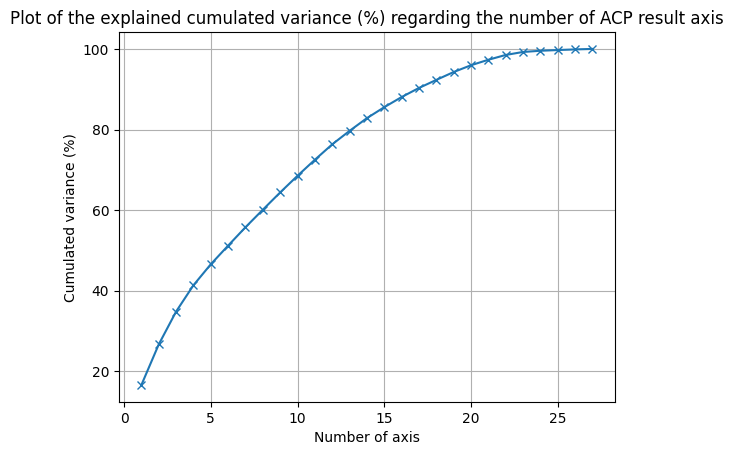

In [79]:
# cumulated variance
varcum = acp.explained_variance_ratio_.cumsum()

# Cumulated variance plot 
plt.plot(range(1, len(varcum) + 1), varcum * 100, marker='x')
plt.xlabel('Number of axis')
plt.ylabel('Cumulated variance (%)')
#plt.title('Graphique de la variance cumulée expliquée selon le nombre de composantes principales')
plt.title('Plot of the explained cumulated variance (%) regarding the number of ACP result axis')
plt.grid(True)
plt.show()

Above 20 axis, it seems useless. I decided to pick 15 axis because 85% is a sufficient variance in my opinion

In [80]:
acp = PCA(n_components=15)
X_acp = acp.fit_transform(dfacpx)

var_tot = sum(acp.explained_variance_ratio_) * 100
print("Total variance :",var_tot,'%')

Total variance : 85.53424724602613 %


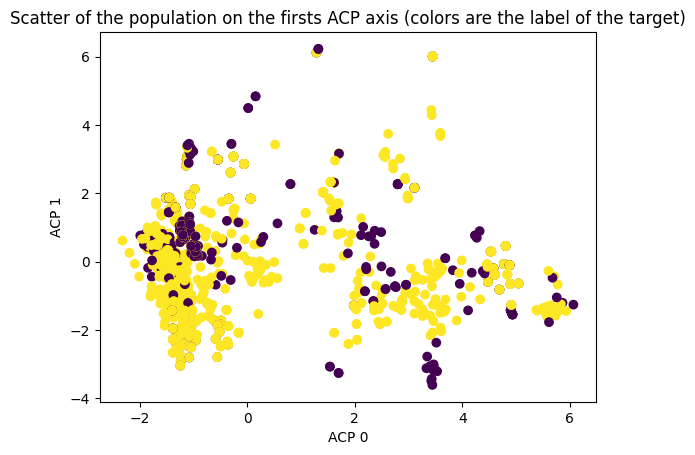

In [81]:
X = pd.DataFrame(X_acp)
y = df['y']
plt.scatter(X[0],X[1],c=y)
plt.title('Scatter of the population on the firsts ACP axis (colors are the label of the target)')
plt.xlabel('ACP 0')
plt.ylabel('ACP 1')
plt.show()

## Modelization  
### Split to obtain the train set (uses for the cross validation) and th test set

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Cross validation with an XGBoost Classifier  
I use a classifier because the target is a binary one and XGBoost is one of the most powerful and common model

In [83]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = xgb.XGBClassifier()

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='roc_auc')
print("AUC of each folds :", cv_scores )
print("Mean Auc",cv_scores.mean())

AUC of each folds : [0.75420816 0.72135666 0.75083893 0.71548418 0.73727075]
Mean Auc 0.7358317356628465


I've used the AUC because it's a common metric, easily interpretable and not dependent on the probability decision threshold.  
The average AUC is 0.73, representing a model with good performance.

### Training and prediction on a fixed dataset

In [84]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

### Vizualisation of the results
#### Volume comparaison and AUC

In [91]:
#Volume results comparaison
print('Real repartition:')
print(pd.DataFrame({'y': y_test})['y'].value_counts())
print('Predicted repartition :')
print(pd.DataFrame({'y': y_pred})['y'].value_counts())
auc = roc_auc_score(y_test, y_pred_proba)
print('\nAUC:',auc)

Real repartition:
y
1    311
0    128
Name: count, dtype: int64
Predicted repartition :
y
1    317
0    122
Name: count, dtype: int64

AUC: 0.7030998794212219


Volumes seem to be balanced and consistent and the AUC is yet not perfect but great
#### Scatter plots comparaison for the first dimensions

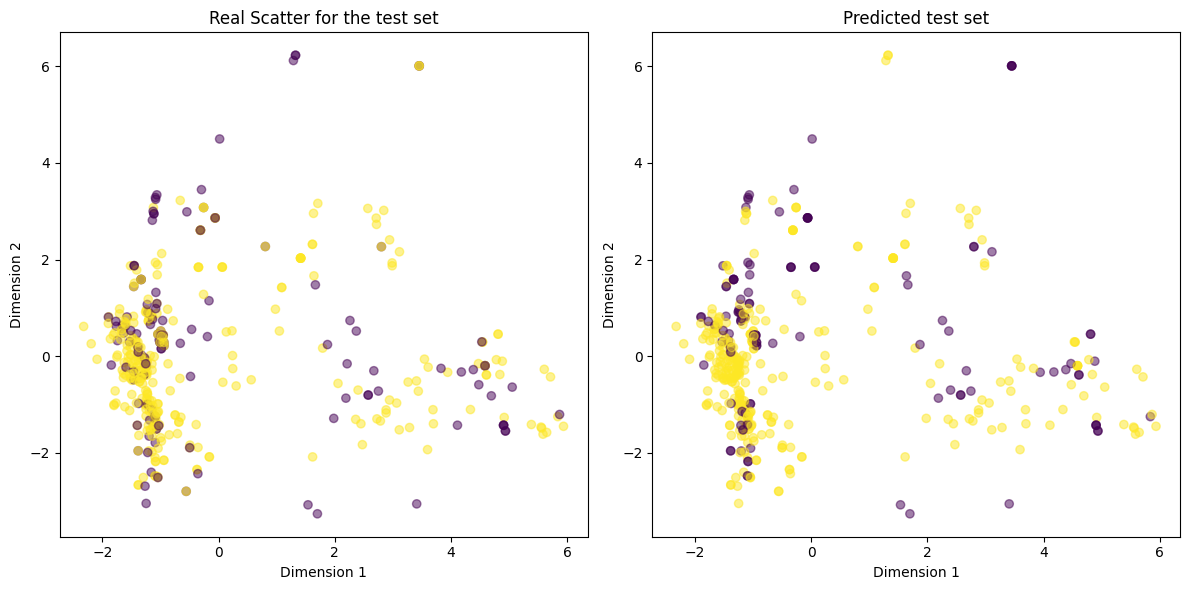

In [85]:
plt.figure(figsize=(12, 6))

#Real
plt.subplot(1, 2, 1)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.title('Real Scatter for the test set')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

#Predicted
plt.subplot(1, 2, 2)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_pred, cmap='viridis', alpha=0.5)
plt.title('Predicted test set')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()


Predictions are following the same shape but we can see multiple differences  
### Confusion matrix

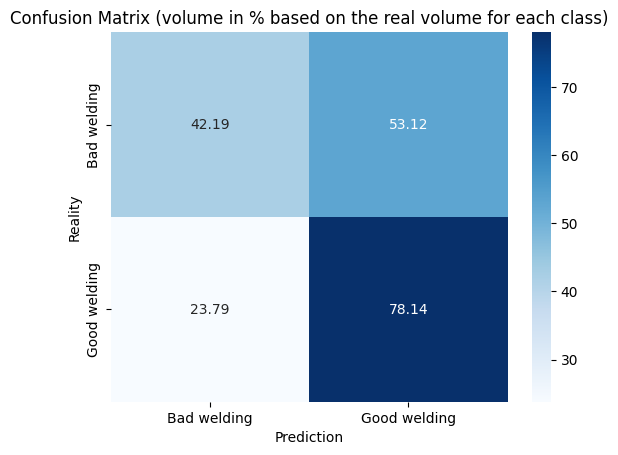

In [105]:
cm = confusion_matrix(y_pred, y_test)
dfcm = []
dfcm.append( cm[0]*100/y_test[y_test==0].shape[0] )
dfcm.append( cm[1]*100/y_test[y_test==1].shape[0] )

sns.heatmap(dfcm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Bad welding', 'Good welding'], yticklabels=['Bad welding', 'Good welding'])
plt.xlabel('Prediction')
plt.ylabel('Reality')
plt.title('Confusion Matrix (volume in % based on the real volume for each class)')
plt.show()

Results are not as good as they seemed. Unfortunately, more than a half of the bad welding are labelled as a good one which can be dangerous is the future. However, my target definition might not be perfect and the results can be representative of a real good one.  

#### To conclude  
this model is biaised to detect well the good welding despite the bad welding. In this context it can be dangerous so maybe we could do oversampling on bad welding to force the model to learn better on the bad welding